## Change the following folders to your own folder

In [2]:
import sys, os

xpipe_folder = "/home/zliang/Documents/xas-data/"
sys.path.append(xpipe_folder)
data_folder = "/home/zliang/Documents/Co_ISS_data/database/"


element = 'Mn'
data_filename = os.path.join(data_folder,f"{element}_data.h5")

## Imports and functions

In [12]:
import numpy as np
import pandas as pd

# import plot modules
import matplotlib.pyplot as plt
%matplotlib inline

from xpipe.utils import *
%reload_ext autoreload
%autoreload 1
%aimport xpipe.utils

import h5py

def to_dataframe(keys, files, data, grid, type_='trans'):
    df_meta = pd.DataFrame({
        'KEY': [int(k) for k in keys],
        'FILE': files,
        'TYPE': [type_] * len(data),
        'LABEL': -1 * np.ones(len(data),dtype=int),
        'SHIFT': np.zeros(len(data),dtype=int)
    })
    df_spec = pd.DataFrame(data=data,
                        columns=[f'ENE_{e:.2f}' for e in grid])
    return pd.concat([df_meta, df_spec], axis=1)

## Read from dataset

In [5]:
# Read raw data into raw_energies, raw_fluos, raw_trans and raw_refs.
fh5 = h5py.File(data_filename, 'r')
key_list = list(fh5.keys())

keys = []
fnames = []
raw_energies = []

keys = {k:k for k in list(fh5.keys())}
fnames = {k:str(fh5[k]['filename'][...]) for k in key_list}
raw_energies = {k:fh5[k]['energy'][...] for k in key_list}
raw_fluos = {k:fh5[k]['fluo'][...] for k in key_list}
raw_trans = {k:fh5[k]['trans'][...] for k in key_list}
raw_refs = {k:fh5[k]['ref'][...]for k in key_list}

In [6]:
fh5['0'].keys()

<KeysViewHDF5 ['energy', 'filename', 'fluo', 'ref', 'trans', 'uid']>

#### Sample plot raw data (optional)

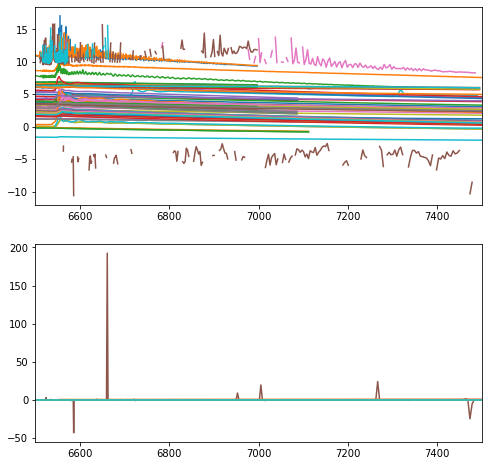

In [7]:
random_key = np.random.choice(key_list,size=100)

fig, axs = plt.subplots(2,1,figsize=(8,8))
for k in random_key:
    axs[0].plot(raw_energies[k],raw_trans[k])
    axs[1].plot(raw_energies[k],raw_fluos[k])
for ax in axs: ax.set_xlim([6500,7500])
# axs[0].axhline(0.1)
# axs[0].set_ylim([-2,2])
# axs[1].set_ylim([-2.5,7.5])
plt.show()

#### delete duplicate energy points (keep average value)

In [8]:
# find the index in raw_energies
for k, grid in raw_energies.items():

    # find the index of duplicated energies
    select_dup = (grid[1:] == grid[:-1])
    index_dup = np.arange(len(grid[:-1]))[select_dup]

    # mask out entries with index in index_dup
    mask = np.ones(len(grid),dtype=bool)
    mask[index_dup] = False
    
    # average values and remove duplicates
    for i in index_dup: 
        # assign averaged value to (i+1)th value because ith will be removed
        raw_trans[k][i+1] = (raw_trans[k][i] + raw_trans[k][i+1])/2
        raw_fluos[k][i+1] = (raw_fluos[k][i] + raw_fluos[k][i+1])/2 
        raw_refs[k][i+1] = (raw_refs[k][i] + raw_refs[k][i+1])/2

    # remove duplicates
    raw_energies[k] = raw_energies[k][mask]
    raw_trans[k] = raw_trans[k][mask]
    raw_fluos[k] = raw_fluos[k][mask]
    raw_refs[k] = raw_refs[k][mask]            

## Featurize data into standard grid

In [9]:
# featurize data into 100 features.
LEFT = 6500
RIGHT = 6700
num_grid = 1000
feature_grid = np.linspace(LEFT,RIGHT,num_grid,endpoint=False)

# construct reduced fluorescence and transmission spectra 
red_keys = []
red_fluos = []
red_transes = []
red_refs = []
fnames_red = []
error_messages = []

for k in fh5.keys():

    # Featurize
    try:
        red_fluo = featurize(feature_grid, (raw_energies[k],raw_fluos[k]),kind='cubic', fill_value='both_ends')
        red_trans = featurize(feature_grid, (raw_energies[k],raw_trans[k]),kind='cubic', fill_value='both_ends')
        red_ref = featurize(feature_grid, (raw_energies[k],raw_refs[k]),kind='cubic', fill_value='both_ends')
    except Exception as e:
        error_messages.append((k,e))
    
    # Ignore if there is nan value
    if np.isnan(red_fluo).any() or np.isnan(red_trans).any() or np.isnan(red_ref).any():
        continue
    
    red_keys.append(k)
    fnames_red.append(fnames[k])
    red_fluos.append(red_fluo)
    red_transes.append(red_trans)
    red_refs.append(red_ref)

fnames_red = np.array(fnames_red)
red_fluos = np.array(red_fluos)
red_transes = np.array(red_transes)
red_refs = np.array(red_refs)

In [10]:
assert len(fnames_red) == len(red_fluos) == len(red_transes) == len(red_refs)

## Subtract background and normalization

In [11]:
# subtract background
red_trans_nobg = subtract_background(red_transes,feature_grid,fit_range=(LEFT,LEFT+25))
red_fluos_nobg = subtract_background(red_fluos,feature_grid,fit_range=(LEFT,LEFT+25))

# normalize transmission and fluorescence data concurrently
keep_mask, red_trans_norm, red_fluos_norm = normalize((red_trans_nobg, red_fluos_nobg),
                                                      grid=feature_grid,
                                                      mean_range=(LEFT,LEFT+25),
                                                      use_derivative=False)

# concatenate trans and fluos data vertically and subtract background
red_norm_fname = [name for name,keep in zip(fnames_red,keep_mask) if keep]
red_norm_key = [key for key, keep in zip(red_keys,keep_mask) if keep]


# normalize the reference data
red_ref_nobg = subtract_background(red_refs,feature_grid,fit_range=(LEFT,LEFT+25))
keep_mask_ref, red_ref_norm, _ = normalize((red_ref_nobg, red_ref_nobg),
                                           grid=feature_grid,
                                           mean_range=(LEFT, LEFT+25),
                                           use_derivative=False)
red_ref_key = np.array([key for key, keep in zip(red_keys,keep_mask_ref) if keep]) 
red_ref_fname = np.array([name for name, keep in zip(fnames_red,keep_mask_ref) if keep])

#### Examine plot for transmission data (optional)

In [16]:
raw = raw_fluos
norm = red_fluos_norm
random_select = np.random.randint(len(red_keys),size=1)

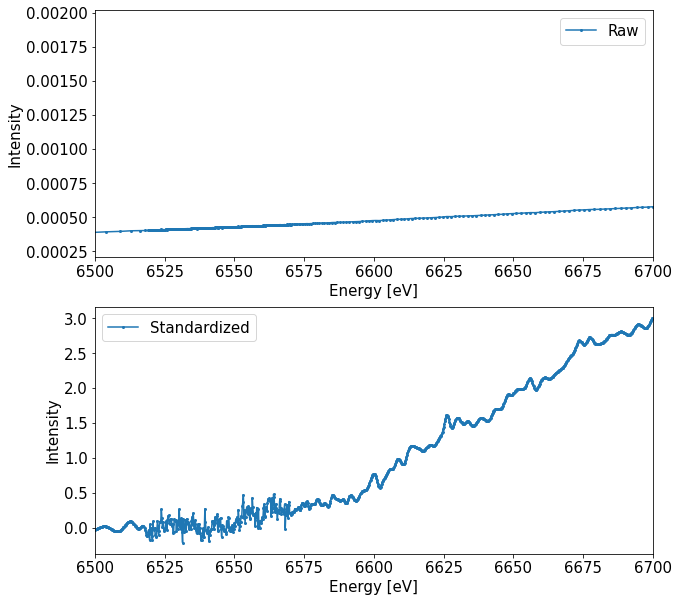

In [19]:
fig, axs = plt.subplots(2,1, figsize=(10,10))
for i in random_select:
    k = red_keys[i]
    axs[0].plot(raw_energies[k],raw[k],marker='.',ms=4,ls='-', label='Raw')
    axs[1].plot(feature_grid,norm[i],marker='.',ms=4,ls='-', label='Standardized')
for ax in axs:
    ax.set_ylabel('Intensity',fontsize=15)
    ax.set_xlabel('Energy [eV]',fontsize=15)
    ax.set_xlim([LEFT, RIGHT])
    ax.legend(fontsize=15)
for ax in axs:
    [text.set_fontsize(15) for text in ax.get_xticklabels()]
    [text.set_fontsize(15) for text in ax.get_yticklabels()]

plt.show()

Total data files selected so far is 

## Create dataframe for transmission, fluorescence and reference data

In [13]:
df_trans = to_dataframe(red_norm_key, red_norm_fname, red_trans_norm, feature_grid, type_='trans')
df_fluos = to_dataframe(red_norm_key, red_norm_fname, red_fluos_norm, feature_grid, type_='fluos')
df_refs = to_dataframe(red_ref_key, red_ref_fname, red_ref_norm, feature_grid, type_='ref')

df = pd.concat([df_trans, df_fluos, df_refs], axis=0)
df_sorted = df.sort_values(by='KEY', axis=0, inplace=False)
df_final = df_sorted.reset_index(inplace=False, drop=True)

#### Save dataframe (optional)

In [201]:
ref_csv_file = "{}_e{}-e{}_grid{}_standard.csv"\
               .format(element, int(LEFT),int(RIGHT),num_grid)
print(ref_csv_file)

Mn_e6500-e6700_grid1000_standard.csv


In [202]:
df_final.to_csv(os.path.join(data_folder, ref_csv_file))

#### Examine plot for dataframe (optional)

In [34]:
num_sample = 100
type_chosen = 'trans'

In [34]:
df_sample = df_final.loc[df_final['TYPE']==type_chosen].sample(n=num_sample)
grid = [float(s.strip('ENE_')) for s in df_sample.columns if s.startswith('ENE_')]
df_plot = df_sample.loc[:,df_sample.columns.str.contains('ENE_')]

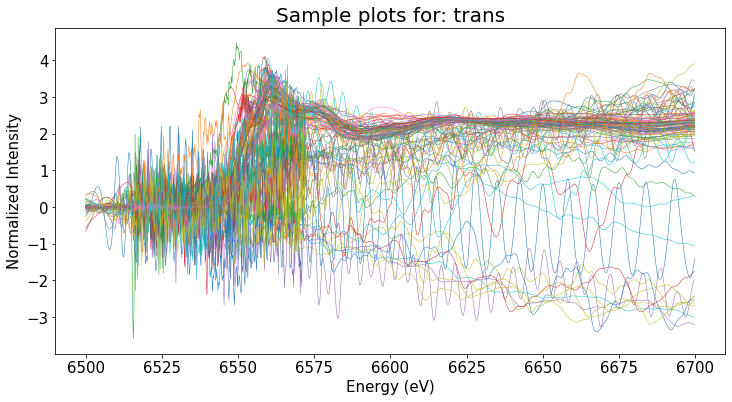

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(grid, df_plot.T, lw=0.5)
[text.set_fontsize(15) for text in ax.get_xticklabels()]
[text.set_fontsize(15) for text in ax.get_yticklabels()]
ax.set_xlabel('Energy (eV)', fontsize=15)
ax.set_ylabel('Normalized Intensity', fontsize=15)
ax.set_title(f"Sample plots for: {type_chosen}", fontsize=20)
plt.show()

In [38]:
df_plot

,ENE_6500.00,ENE_6500.20,ENE_6500.40,ENE_6500.60,ENE_6500.80,ENE_6501.00,ENE_6501.20,ENE_6501.40,ENE_6501.60,ENE_6501.80,...,ENE_6698.00,ENE_6698.20,ENE_6698.40,ENE_6698.60,ENE_6698.80,ENE_6699.00,ENE_6699.20,ENE_6699.40,ENE_6699.60,ENE_6699.80
6518,0.010338,0.010296,0.010242,0.010179,0.010109,0.010035,0.009959,0.009883,0.009811,0.009744,...,0.988383,0.990584,0.988992,0.984271,0.977145,0.968344,0.958593,0.948620,0.939152,0.930916
8040,0.006510,0.005608,0.004632,0.003592,0.002497,0.001357,0.000182,-0.001018,-0.002234,-0.003457,...,2.281596,2.282142,2.281307,2.279370,2.276633,2.273399,2.269968,2.266643,2.263725,2.261517
19650,-0.001916,-0.001976,-0.002018,-0.002042,-0.002049,-0.002039,-0.002014,-0.001974,-0.001920,-0.001853,...,2.274232,2.274118,2.274078,2.274147,2.274360,2.274750,2.275339,2.276108,2.277025,2.278061
22677,0.010692,0.010871,0.011041,0.011200,0.011345,0.011474,0.011582,0.011664,0.011717,0.011736,...,2.414016,2.411900,2.410218,2.409128,2.408788,2.409354,2.410912,2.413291,2.416262,2.419599
188,0.002715,0.003068,0.003425,0.003780,0.004129,0.004467,0.004789,0.005090,0.005365,0.005609,...,2.222497,2.222829,2.222964,2.222959,2.222872,2.222764,2.222693,2.222719,2.222900,2.223297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20963,-0.023575,-0.026576,-0.030545,-0.035384,-0.040996,-0.047282,-0.054147,-0.061491,-0.069218,-0.077231,...,2.694000,2.690381,2.690676,2.695824,2.706764,2.724434,2.749302,2.780191,2.815562,2.853876
23905,0.005103,0.004832,0.004563,0.004298,0.004035,0.003777,0.003522,0.003271,0.003025,0.002784,...,2.536140,2.537371,2.538678,2.540086,2.541620,2.543304,2.545155,2.547152,2.549271,2.551487
6657,-0.068185,-0.067538,-0.066791,-0.065942,-0.064990,-0.063936,-0.062778,-0.061515,-0.060146,-0.058671,...,2.704188,2.707419,2.710893,2.714544,2.718304,2.722106,2.725882,2.729564,2.733085,2.736377
21250,0.264015,0.246257,0.226179,0.204134,0.180478,0.155567,0.129755,0.103397,0.076848,0.050464,...,2.096979,2.128322,2.163592,2.204743,2.253730,2.312508,2.381924,2.458950,2.539708,2.620322
